In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']

#gd = pytpc.fitting.GDescent(config)

In [29]:
#Good events for run_0102 are: 689 (fair ~37), 765 (good), 896 (good), 305 (perfect), 504 (not good ~65)
#575, 456, 299, 399
full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
evt_ID = 399
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

In [30]:
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)

In [31]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_values = uvw.values

In [32]:
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000


In [33]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
print(exp_hits)


[0. 0. 0. ... 0. 0. 0.]


In [34]:
minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
#ctr = np.zeros([1,6])
#ctr[0] = ctr0
print(ctr0)

[ 0.          0.          0.50258247  1.85464885 -0.57232143  1.59202326]


Conjugate Gradient

In [40]:
def f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def jacobian(x):
    return scipy.optimize.approx_fprime(x,f,eps)

print(f(ctr0))
print(jacobian(ctr0))


110.89598043726828
[ -18.66422749   29.72856045 -872.90955162    2.0765934    -2.01852798
  487.89533615]


In [41]:
i = 1
def callbackF(x):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1    
    
#scipy.optimize.minimize(f, ctr0, method="CG", jac=jacobian, callback=callbackF, options={'gtol': 30.0, 'eps':eps})    

In [42]:
results = scipy.optimize.minimize(f, ctr0, method="CG", jac=jacobian, callback=callbackF, options={'gtol': 30.0, 'eps':eps})    
cg = results.x

   1 0.000002-0.000004 0.502694 1.854649-0.572321 1.591961 110.822385


In [43]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(cg[0], cg[1], cg[2], cg[3], cg[4], cg[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


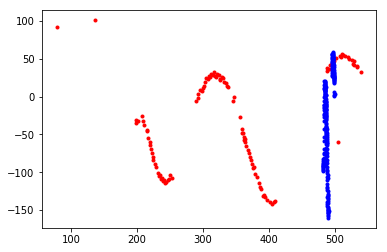

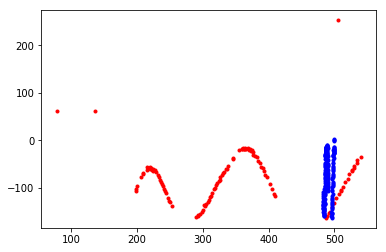

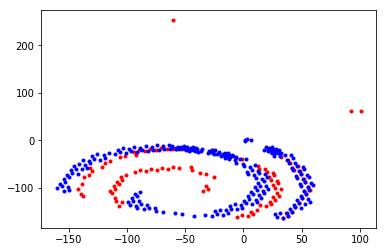

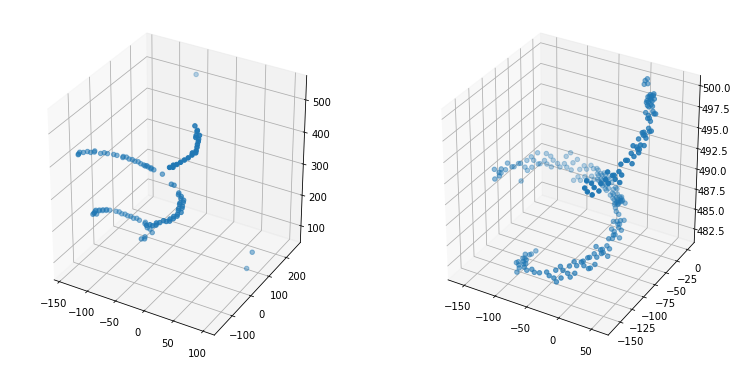

In [44]:
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,5],uvw_values[:,6],uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])

In [45]:
scipy.optimize.fmin_bfgs(f, ctr0, fprime=jacobian, callback=callbackF)

   2 0.000205-0.000327 0.512193 1.854626-0.572299 1.586652 110.433213
         Current function value: 110.433213
         Iterations: 1
         Function evaluations: 73
         Gradient evaluations: 66


array([ 2.05479436e-04, -3.27289616e-04,  5.12192558e-01,  1.85462599e+00,
       -5.72299211e-01,  1.58665189e+00])

Differential Evolution

In [46]:
i = 1
def callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
results = scipy.optimize.differential_evolution(f, bounds, callback=callbackF, maxiter=10000, strategy='best1bin',\
                                                recombination=0.6, popsize=30, mutation=(0.5, 1.0))
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

   1-0.011500 0.043764 0.570328 4.485145-0.576003 1.555083 151.395103
   2 0.012152-0.030538 0.479537 2.702255-3.489426-0.285810 129.187624
   3 0.012152-0.030538 0.479537 2.702255-3.489426-0.285810 129.187624
   4 0.021755-0.022044 0.491822 3.377597-4.027192-1.718511 121.605551
   5-0.026084 0.015912 0.581070 2.993202-3.503382 4.270485 112.660785
   6-0.026084 0.015912 0.581070 2.993202-3.503382 4.270485 112.660785
   7-0.001300 0.004440 0.216976 1.976259 1.760979-0.749120 106.736134
   8-0.001300 0.004440 0.216976 1.976259 1.760979-0.749120 106.736134
   9-0.001300 0.004440 0.216976 1.976259 1.760979-0.749120 106.736134
  10-0.001300 0.004440 0.216976 1.976259 1.760979-0.749120 106.736134
  11 0.000443-0.008808 0.013030 3.917003 4.434167 0.102555 104.889217
  12 0.005380 0.005238 0.645737 2.883670-4.305349 3.441996 103.517662
  13-0.006917 0.005298 0.622526 2.751885-6.244726-3.615554 94.924195
  14-0.006917 0.005298 0.622526 2.751885-6.244726-3.615554 94.924195
  15-0.006917 0.005298

 120 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 121 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 122 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 123 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 124 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 125 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 126 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 127 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 128 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 129 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 130 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 131 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 132 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 133 0.000374 0.001647 0.882600 2.787169 2.733527-1.942275 63.174582
 134 0.000374 0.001647 0.882600 2.

 239 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 240 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 241 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 242 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 243 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 244 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 245 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 246 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 247 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 248 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 249 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 250 0.007733 0.000769 0.804384 2.971270 2.603255-1.873821 42.858129
 251 0.001628 0.010924 0.802555 3.090132 2.745343-1.860129 37.504710
 252 0.001628 0.010924 0.802555 3.090132 2.745343-1.860129 37.504710
 253 0.001628 0.010924 0.802555 3.

'    The differential evolution strategy should be one of:\n            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result\n            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result\n            ‘rand1exp’ - takes a long time but converges\n            ‘randtobest1exp’ - takes a long time but converges\n            ‘currenttobest1exp’ - takes a long time but converges\n            ‘best2exp’\n            ‘rand2exp’\n            ‘randtobest1bin’\n            ‘currenttobest1bin’\n            ‘best2bin’\n            ‘rand2bin’\n            ‘rand1bin’\n    The default is ‘best1bin’.\n'

In [47]:
results.fun

27.327318477448138

In [48]:
dfe = results.x
print(dfe)
#evt_299:[ 7.84428822e-03  3.53398504e-03  9.23208704e-01  2.58491529e+00 -9.73837034e-01 -4.45947600e+00]
#evt_399: [ 0.00773186  0.01781402  0.8011877   3.11712508 -0.46023263 -4.4246107 ]


[ 0.00889907  0.01800327  0.80272527  3.10926429  2.67747809 -1.86015342]


In [49]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(dfe[0], dfe[1], dfe[2], dfe[3], dfe[4], dfe[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [50]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

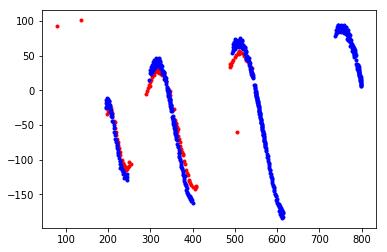

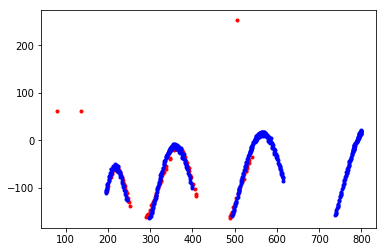

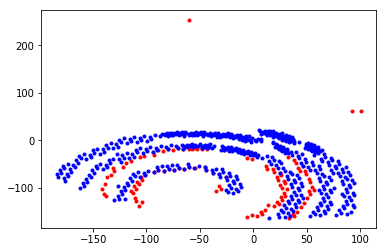

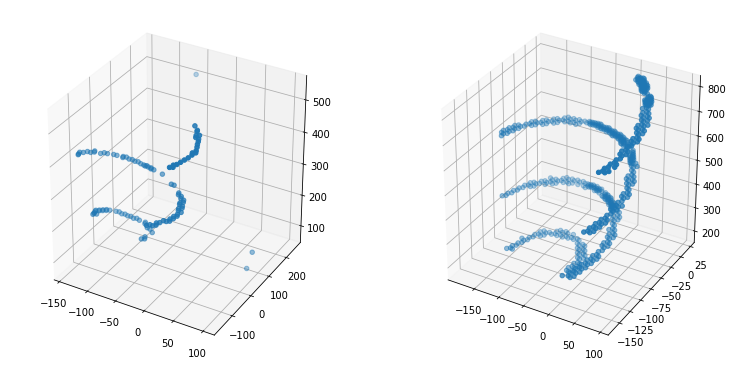

In [51]:
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,5],uvw_values[:,6],uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])

In [22]:
#i = 1
#def callbackF(f):
#    global i
#    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
#    i += 1

scipy.optimize.basinhopping(f,ctr0)

                        fun: 35.84932841740407
 lowest_optimization_result:       fun: 35.84932841740407
 hess_inv: array([[ 3.24951140e-04,  5.24354063e-04,  3.56428677e-04,
         1.62077330e-02,  7.48447316e-03, -1.27891402e-03],
       [ 5.24354063e-04,  5.98719563e-03,  2.90892006e-03,
        -3.98537563e-03,  7.70471381e-02,  8.24804760e-04],
       [ 3.56428677e-04,  2.90892006e-03,  1.46370241e-03,
         4.15094971e-03,  3.77580742e-02, -8.10531241e-05],
       [ 1.62077330e-02, -3.98537563e-03,  4.15094971e-03,
         1.01454256e+00, -6.76365616e-03, -8.34278295e-02],
       [ 7.48447316e-03,  7.70471381e-02,  3.77580742e-02,
        -6.76365616e-03,  9.94971530e-01,  6.98046211e-03],
       [-1.27891402e-03,  8.24804760e-04, -8.10531241e-05,
        -8.34278295e-02,  6.98046211e-03,  6.93078539e-03]])
      jac: array([ 309.90463972, -160.63703489,  272.88521242,  -21.33727503,
         -5.63922119, -482.84249687])
  message: 'Desired error not necessarily achieved du